Exercise 3:
In a recent paper [[8]](https://journals.aps.org/prresearch/pdf/10.1103/PhysRevResearch.5.043044), the tools from dynamical systems were used to exactly compute the Lyapunov spectrum and the attractor dimension (through the Kaplan-Yorke conjecture) of this high-dimension system. Reproduce their results through Fig. 4.

In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [4]:
h = 0.01
rng = np.random.default_rng()

# Generate an NxN matrix with J_{ij} ~ N(mu, sigma) and J_{ii} = 0
def generate_J(N, mu, sigma):
    J = np.random.normal(mu, sigma, (N, N))
    np.fill_diagonal(J, 0)
    return J

# Define the transfer function as tanh
def phi(x):
    return np.tanh(x)

# Calculate the update value (derivative) for all neurons
def dr_dt(r, J, tau):
    drdt = (-r + np.dot(J, phi(r))) / tau
    return drdt

# Define the Runge Kutta 4 integrator
def runge_kutta(x, J, tau):
    k1 = h * dr_dt(x, J, tau)
    k2 = h * dr_dt(x + k1 / 2, J, tau)
    k3 = h * dr_dt(x + k2 / 2, J, tau)
    k4 = h * dr_dt(x + k3, J, tau)
    x_new = x + (k1 + 2 * k2 + 2 * k3 + k4) / 6
    return x_new

In [16]:
# Run the simulation of the neuron system with initial positions that are all orthonormal
def run_simulation_orthonormal_starts(N, steps, tau, mu, g):
    sigma = g / np.sqrt(N)
    J = generate_J(N, mu, sigma)

    x_all = np.zeros((steps, N, N))

    x = np.eye(N)  # Each column of x is an orthonormal starting position

    # Evolve all the starting positions for some time steps
    for start_pos in range(N):
        x_start = x[:, start_pos]

        for i in range(steps):
            x_start = runge_kutta(x_start, J, tau)
            x_all[i, :, start_pos] = x_start

    return x_all

# Get the QR decomposition matrix for all timesteps of the simulation dataset
def qr_decomposition_timesteps(x_all, steps, N):
    R_matrices = []

    new_axis = np.eye(N)
    for i in range(steps):
        matrix_at_timestep = x_all[i, :, :]

        # Perform QR decomposition based on the neurons at timestep t, scaled by Q
        Q, R = sp.linalg.qr(np.matmul(np.eye(N)+matrix_at_timestep*h, new_axis))
        new_axis = Q

        R_matrices.append(R)

    return R_matrices

# Calculate the Lyapunov exponents based on the R matrices
def exponents_spectrum(R_matrices, steps):
    m = R_matrices[0].shape[0]

    diagonal_sum = np.zeros(m)

    for i in range(steps):
        R = R_matrices[i]

        diagonal_sum += np.log(np.abs(np.diag(R)))

    exponents = diagonal_sum / steps

    return exponents

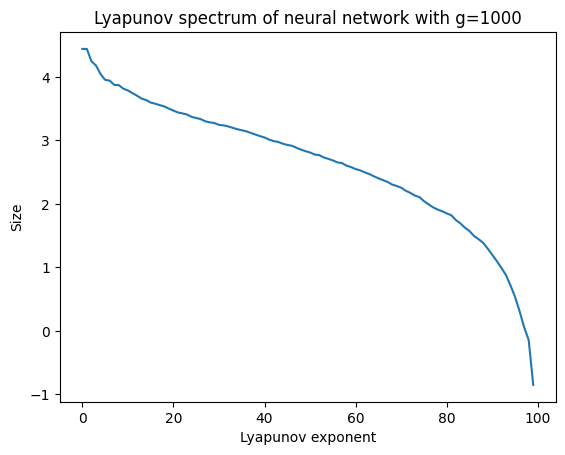

In [18]:
g = 1000

x_all = run_simulation_orthonormal_starts(100, 1000, 1, 0, g)
R_matrices = qr_decomposition_timesteps(x_all, 1000, 100)
diagonal_avg = exponents_spectrum(R_matrices, 1000)

plt.plot(diagonal_avg)
plt.title(f"Lyapunov spectrum of neural network with g={g}")
plt.xlabel("Lyapunov exponent")
plt.ylabel("Size")
plt.show("Size")

The above is an attempt at finding the Lyapunov spectrum of the neural network. The range of the size of the lyapunov exponents is roughly equal to those calculated in the reference paper. Unfortunately, the shape of the curve does not correspond well. Particularly, the spectrum we calculated is concave down and decreasing, while the reference paper calculated it to be concave up and decreasing. Unfortunately we were unable to figure out why exactly we could not get the same results.